In [1]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
    Lambda,
)
from monai.utils import set_determinism

from models.ConvAE import ConvolutionalAutoencoder

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Create small visualisation function
import nibabel as nib

def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        if isinstance(im, str): im = nib.load(im).get_fdata().astype(int) 
        im = plt.imread(im) if isinstance(im, str) else np.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [3]:
!pwd

/data/marciano/experiments/multi-organ-qc/moqc/notebooks


In [4]:
%cd ..

/data/marciano/experiments/multi-organ-qc/moqc


In [5]:
%cd ..

/data/marciano/experiments/multi-organ-qc


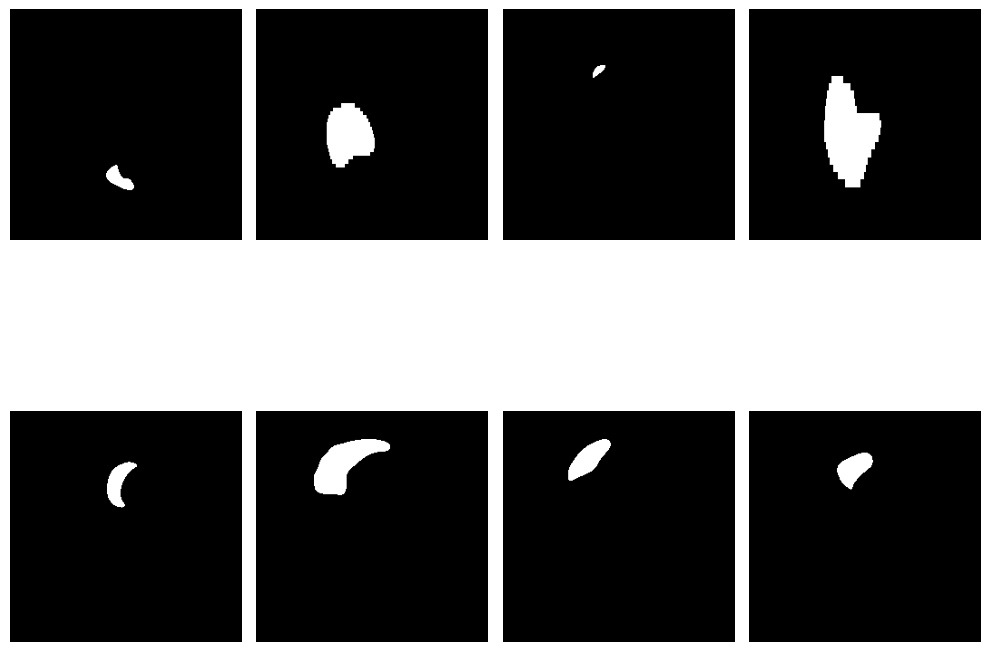

In [6]:
organ = 'spleen'
DATA_PATH = os.path.join("data", organ)
mask_path = os.path.join(DATA_PATH, "structured")

all_filenames = [os.path.join(mask_path, filename, "mask.nii.gz") for filename in os.listdir(mask_path)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2, 4))

In [7]:
test_frac = 0.2
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 37
number of images for training: 30
number of images for testing: 7


In [8]:
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }
)

train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

/data/marciano/my_envs/FORE/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [9]:
batch_size = 4
num_workers = 8

train_ds = CacheDataset(train_datadict, train_transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, test_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Loading dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 7/7 [00:00<00:00, 369.84it/s]


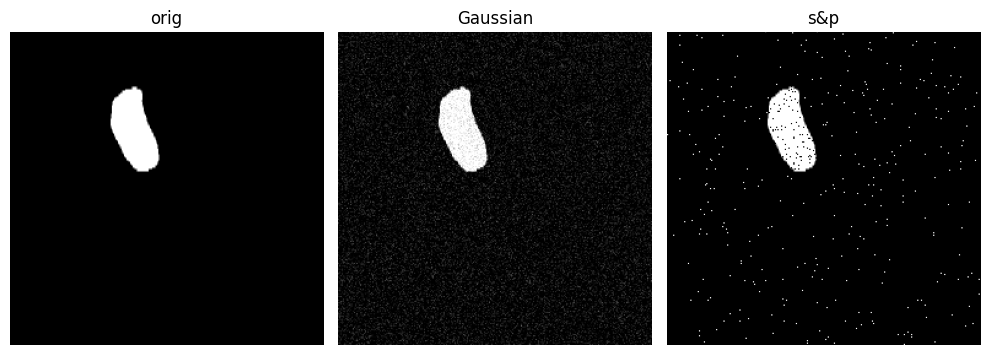

In [10]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=8, shuffle=True)
    itera = iter(loader)
    return next(itera)

data = get_single_im(train_ds)
plot_ims([data["orig"], data["gaus"], data["s&p"]], titles=["orig", "Gaussian", "s&p"])

In [17]:
def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3):
    model = AutoEncoder(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(8, 16, 32, 32, 64, 64),
        strides=(2, 2, 2, 1, 2, 1),
        inter_channels=(100, ),
        inter_dilations=(2, )
    ).to(device)
    
    # Create loss fn and optimiser
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

    epoch_loss_values = []

    t = trange(max_epochs, desc=f"{dict_key_for_training} -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data[dict_key_for_training].to(device).squeeze(2)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs.to(device).squeeze(2), batch_data["orig"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        t.set_description(f"{dict_key_for_training} -- epoch {epoch + 1}" + f", average loss: {epoch_loss:.4f}")
    return model, epoch_loss_values

In [21]:
max_epochs = 500
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []
for training_type in training_types:
    model, epoch_loss = train(training_type, max_epochs=max_epochs)
    models.append(model)
    epoch_losses.append(epoch_loss)

orig -- epoch 0, avg loss: inf:   0%|          | 0/500 [00:00<?, ?it/s]

s&p -- epoch 500, average loss: 0.0170: 100%|██████████| 500/500 [05:17<00:00,  1.58it/s]


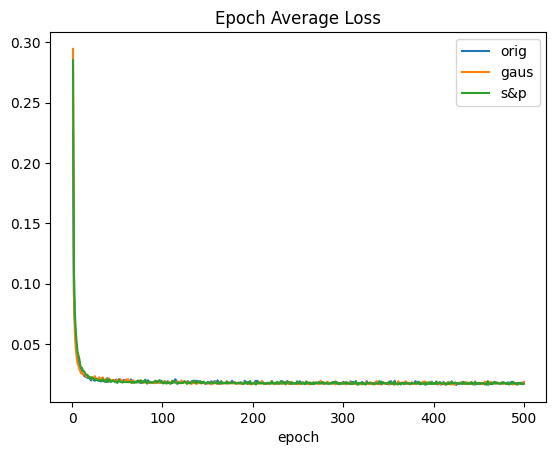

In [22]:
plt.figure()
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
for y, label in zip(epoch_losses, training_types):
    x = list(range(1, len(y) + 1))
    (line,) = plt.plot(x, y)
    line.set_label(label)
plt.legend()

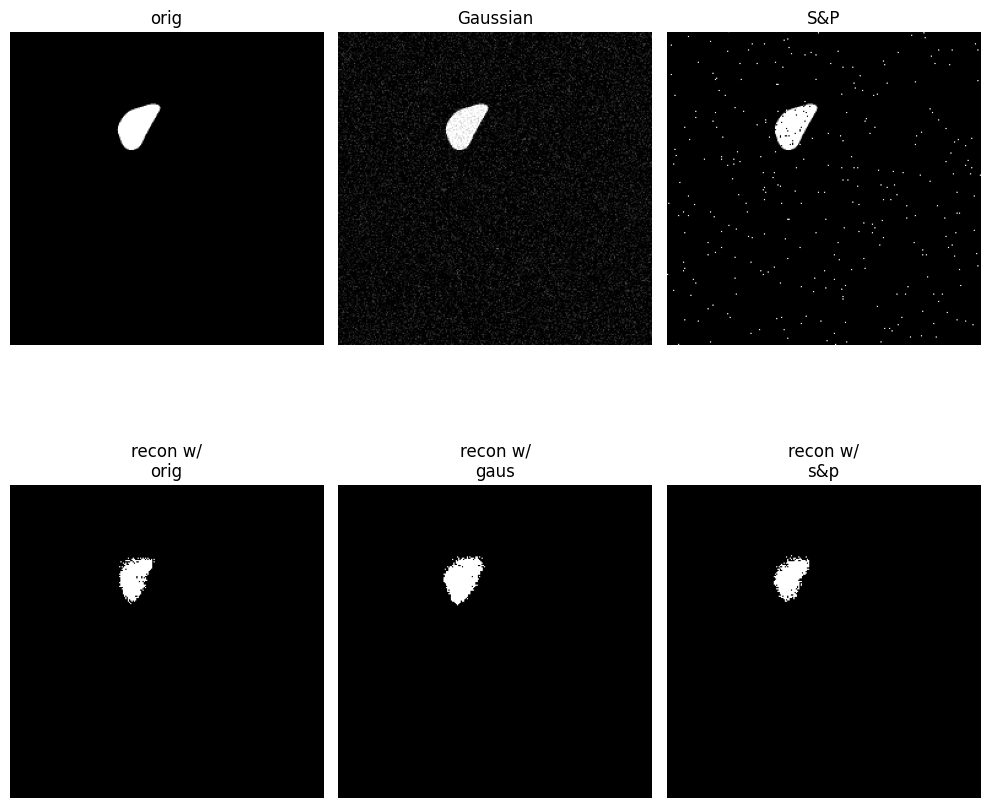

In [33]:
data = get_single_im(test_ds)

recons = []
for model, training_type in zip(models, training_types):
    im = data[training_type]
    recon = torch.where(model(im.to(device).squeeze(2))> 0.3, 1, 0).detach().cpu()
    recons.append(np.squeeze(recon))

plot_ims(
    [data["orig"], data["gaus"], data["s&p"]] + recons,
    titles=["orig", "Gaussian", "S&P"] + ["recon w/\n" + x for x in training_types],
    shape=(2, len(training_types)),
)